# Explorative Data Analysis

This notebook is the basis for the explorative data analysis for **Task 1.1**.

The task is as follows:

> Perform an exhaustive dataset analysis to explore the attributes of the TDT4265 dataset. The analysis should highlight commonalities, limitations and perhaps interesting samples in the dataset (both images and labels). You are free to choose how to present the analysis, and the analysis can be both statistical and qualitative. To get you started, you can try to analyze the size of the objects in the dataset.

For more information, these blog posts have been used for inspiration:
* [Popular Object Detection datasets - Analysis and Statistics](https://medium.com/@vijayshankerdubey550/popular-object-detection-datasets-analysis-and-statistics-66acdacc3aa9) (Medium article)
* [How to Do Data Exploration for Image Segmentation and Object Detection](https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection) (Neptune blog)
* [How to work with object detection datasets in COCO format](https://towardsdatascience.com/how-to-work-with-object-detection-datasets-in-coco-format-9bf4fb5848a4) (Medium article)
* [Visualizing Object Detections](https://medium.com/voxel51/visualizing-object-detections-9d0ed766297c) (Medium article)

This lead to the following points of interest:
* Intra-class variability (Low variability can be a limitation)
* Inter-class variability (distinguish between classes, while able to distinguish between high intra-class variability)
* Image size
* Class imbalance
* Object size to image size
* Background clutter (RCNN and FRCNN produces many false positives)
* Occlusion (The more occluded objects are the more difficult they are to detect)

And these interesting statistics:
* Number of objects per category
* Number of objects contained in a single image
* Size of the images present in the dataset
* Ratio of areas of Object size and Image size, for each object present in the image
* Overlap between objects

### Settings

In [2]:
# Autoimport changes in code
%load_ext autoreload
%autoreload 2

# Import system modules and include ../SSD in path
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

# Set working directory to SSD folder
# NB! Running this cell several times will continue to move upwards in the directories.
print('Working directory:')
%cd ../

# Third party libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from ssd import utils

# Local libraries
from dataset_exploration.dataset_statistics import (
    get_config,
    get_dataloader,
)

# Set seed
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

Working directory:
/Users/mariu/dev/school/TDT4265/project/computer-vision-and-deep-learning/SSD


### Load Dataset

Only the training data will be used in the statistical analysis.

In [3]:
# Load config
cfg = get_config(config_path="configs/tdt4265.py")

# Get dataloader
dataloader = get_dataloader(cfg, dataset_to_analyze="train")

Saving SSD outputs to: outputs/


In [4]:
# Verify that the dataset is available
dataset_obj = dataloader.dataset

### Visualize dataset

Using fiftyone we can visualize the dataset. The session can be started by running:

```
session = fo.launch_app(dataset_fo)
```

To take screenshots run:

```
session.freeze()
```

In [5]:
import fiftyone as fo
from fiftyone import ViewField as F

data_path = 'data/tdt4265_2022/'
labels_path = 'data/tdt4265_2022/train_annotations.json'

# Fiftyone version of dataset
dataset_fo = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    name='tdt4265-dataset',
)

NumExpr defaulting to 8 threads.
 100% |███████████████| 1604/1604 [5.9s elapsed, 0s remaining, 352.7 samples/s]      


## Statistics

Exploring statistics such as:
* Number of objects per category
* Number of objects contained in a single image
* Size of the images present in the dataset
* Ratio of areas of Object size and Image size, for each object present in the image
* Overlap between objects

In [6]:
# Get basic information
label_map = dataset_obj.label_info

# Get data and unwrap
data = dataset_obj.data
annotations, images, categories = data['annotations'], data['images'], data['categories']

In [7]:
# Calculate number of objects per category
categories_count = {i: 0 for i in range(1, len(categories) + 1)}

for annotation in annotations:
    category_id = annotation['category_id']
    categories_count[category_id] += 1

In [8]:
# Interestingly enough, this line does the same as the one above:
counts_fo = dataset_fo.count_values("ground_truth.detections.label")

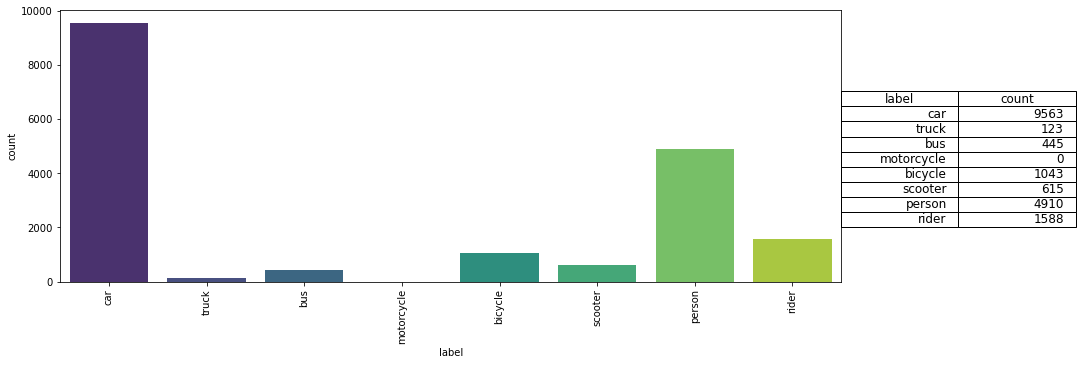

In [9]:
# Plot histogram and table

object_labels = {key: value for key, value in label_map.items() if key != 0}
df_categories = pd.DataFrame.from_dict([object_labels, categories_count]).T
df_categories.rename({0: 'label', 1: 'count'}, axis=1, inplace=True)

plt.figure(figsize=(14, 5))
sns.barplot(x='label', y='count', data=df_categories, palette='viridis')
plt.xticks(rotation=90)
table = plt.table(cellText=df_categories.values,
                  rowLabels=None,
                  colLabels=df_categories.columns,
                  cellLoc='right',
                  rowLoc='center',
                  loc='right',
                  bbox=[1., .2, .3, .5])
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.show()

The dataset is clearly imbalanced. We see that *car* is the most represented class by far, only followed by *person*. This means it will be very difficult to train a good model to detect the other objects solely based on this dataset. The high class imbalance should be accounted for. Options:
 * Over- or downsample the dataset and control each class contribution to the loss.
 * Add weights to the loss (making the contirbutions of some boxes or pixels higher).
 * Preprocessing the data in another way, e.g. by custom cropping to rebalance the dataset on the object level.

In [64]:
# Calculate checksum of dict
def checksum(dict, total_number):
    s = 0
    for key, value in dict.items():
        s += key * value

    # Should be equal to the total number of objects
    assert s == total_number, f'Expected: {total_number}, got: {s}'

In [65]:
# Keys indicate number of objects in image, value is number of images with same number of objects
objects_per_image_dict = {}

for sample in dataset_fo:
    c = len(sample.ground_truth.detections)
    if c in objects_per_image_dict:
        objects_per_image_dict[c] += 1
    else:
        objects_per_image_dict[c] = 1

checksum(objects_per_image_dict, len(annotations))

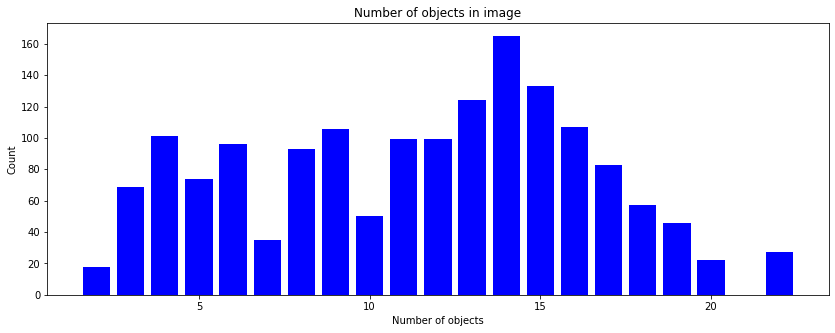

In [11]:
# Plot number of objects contained in an image
plt.figure(figsize=(14, 5))
# sns.barplot(x=list(objects_per_image_dict.keys()), y=list(objects_per_image_dict.values()), palette='viridis')
plt.bar(list(objects_per_image_dict.keys()), list(objects_per_image_dict.values()), color='blue')
plt.title('Number of objects in image')
plt.xlabel('Number of objects')
plt.ylabel('Count')
plt.show()

The majority of the images contains 14 objects (about 10%). Nonetheless, the histogram shows that most images contain 3 and 17 objects. This could impact model performance if the model learns that most images contains a certain number or range of number of objects.

In [12]:
# Calculate average number of objects in each image
average_objects_per_image = df_categories['count'].sum() / len(images)
print(f'Average number of objects per image: {average_objects_per_image:.2f}')

Average number of objects per image: 11.40


In [13]:
# Get image size
image_size = (images[0]['width'], images[0]['height'])
print(f'Image size: {image_size[0]} x {image_size[1]} (width x height)')

Image size: 1024 x 128 (width x height)


Since the image aspect ratios are uniformly distributed (all of the images have the same dimensions), the only decision we will have to make is how much to resize (if at all). This will mainly depend on objects area, size and aspect ratios.

In [49]:
# Calculate ratio of areas of object size and image size, for each object present in each image
def calculate_object_areas(dataset):
    # Stores ratio of object area to image area
    # key: int representation of float area, value: count of objects with that ratio
    ratios_dict = {}
    for sample in dataset:
        bboxes = sample.ground_truth.detections
        for obj in bboxes:
            bbox = obj.bounding_box
            # Note, bounding boxes in fiftyone are represented as: [<top-left-x>, <top-left-y>, <width>, <height>]
            # Also, the coordinates are relative to the image size, not the image size divided by the bounding box size
            ratio = bbox[2] * bbox[3]
            if ratio in ratios_dict:
                ratios_dict[ratio] += 1
            else:
                ratios_dict[ratio] = 1

    return ratios_dict


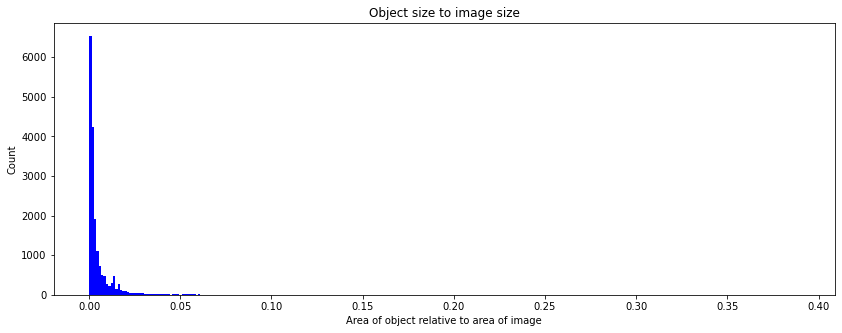

Mean: 0.005998
Standard deviation: 0.017635


In [179]:
ratios_dict = calculate_object_areas(dataset_fo)
# Plot object ratios to image size
plt.figure(figsize=(14, 5))
# plt.hist(list(ratios_dict.keys()), list(ratios_dict.values()), bin=, color='blue')
ratios_as_list = [key for key, value in ratios_dict.items() for _ in range(value)]
plt.hist(ratios_as_list, bins=300, color='blue')
plt.title('Object size to image size')
plt.xlabel('Area of object relative to area of image')
plt.ylabel('Count')
plt.show()

# Calculate mean and std
mean = np.mean(ratios_as_list)
std_all = np.std(ratios_as_list)

print(f'Mean: {mean:.6f}')
print(f'Standard deviation: {std_all:.6f}')

The histogram confirms that most objects are small relative to the image size.

Overall the ratio is quite close to 0 for majority of the objects. This motivates us to crop the images into several patches and use it for training and inference, instead of resizing it to a smaller size, as used by the standard object detectors.

However, one should note that there exists images of buses covering 30-40% of the image. Again a case of samples that are difficult to train a model on with the current dataset.

In [16]:
# Measuring Overlap between objects in an image with IoU

# This is done by plotting IoU Area against Number of overlapping objects
# Hence, we have to calculate the IOU for each object in each image

from utils import calculate_iou

"""
Inputs for the calculate_iou function:

    prediction_box (np.array of floats): location of predicted object as
        [xmin, ymin, xmax, ymax]
    gt_box (np.array of floats): location of ground truth object as
        [xmin, ymin, xmax, ymax]

Note, bounding boxes in fiftyone are represented as: [<top-left-x>, <top-left-y>, <width>, <height>]
"""

def transform_bbox(bbox):
    # Transform to [xmin, ymin, xmax, ymax] from [<top-left-x>, <top-left-y>, <width>, <height>]
    return [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]

# key: IoU, value: count of objects that overlap with that IoU
iou_areas = {}

for sample in dataset_fo:
    bboxes = sample.ground_truth.detections
    for obj in bboxes:
        bbox = obj.bounding_box
        # For each bbox, calculate the IOU with all other bboxes in image
        for other_obj in bboxes:
            other_bbox = other_obj.bounding_box
            iou_area = calculate_iou(transform_bbox(bbox), transform_bbox(other_bbox))
            if iou_area in iou_areas:
                iou_areas[iou_area] += 1
            else:
                iou_areas[iou_area] = 1

# Remove self and no overlap
iou_areas.pop(0.0)
iou_areas.pop(1.0)

18287

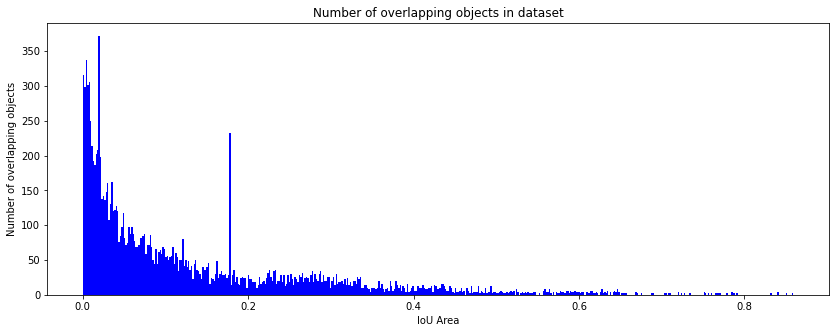

In [17]:
# Plot overlap between objects in an image with IoU
plt.figure(figsize=(14, 5))
ious_as_list = [key for key, value in iou_areas.items() for _ in range(value)]
plt.hist(ious_as_list, bins=500, color='blue')
plt.title('Number of overlapping objects in dataset')
plt.xlabel('IoU Area')
plt.ylabel('Number of overlapping objects')
plt.show()

The histogram above shows that there is a significant amount of overlap between objects in the dataset. The distribution is also long-tailed, indicated that there are a considerable amount of samples where there is more than 50% overlap between objects. This means the model will be trained on a lot of data without overlap, and only some with. Hence, augmenting with a focus on creating more crowds or overlaps could be valuable to increase the model performance when there are a lot of object overlaps. Other ideas for obtaining more information about objects with overlap could be to use Oriented Bounding Boxes (OBB).

In [306]:
# Check these out:
#TODO: Calculate object size data for each class? Or do we have enough?
#TODO: Mean area of bounding box per category Figure?
#TODO: Intra- and inter-class variability - We could do several of the current analyses on individual classes.
#TODO: Histogram of objects aspect ratios in the dataset? By label as well?

In [29]:
# Calculate area for each bounding box

# Bboxes are in [top-left-x, top-left-y, width, height] format
bbox_area = F("bounding_box")[2] * F("bounding_box")[3]

# Only include predictions with `confidence` of at least 0.9
view = dataset_fo.set_field(
    "ground_truth.detections",
    F("detections").map(F().set_field("area", bbox_area))
)

print(view.bounds("ground_truth.detections.area"))

(7.621765136718754e-05, 0.38945312500000007)


In [115]:
# Calculate mean area of bounding box per category

# key: class_name, value: list of areas of bounding box
bbox_category_areas = {}

for _, label in object_labels.items():
    label_objects = 2
    area_list = list(filter(lambda x: object_labels[x['category_id']] == label, annotations)) 
    area_list_scaled = [x['area'] / (image_size[0] * image_size[1]) for x in area_list]
    bbox_category_areas[label] = area_list_scaled

    # Check that the correct number of areas are present
    a = len(bbox_category_areas[label])
    try:
        t = counts_fo[label]
    except KeyError:
        print(f'No {label} found in annotations, removing...')
        bbox_category_areas.pop(label)
        continue
    assert a == t, f'Expected {t}, got {a}'

No motorcycle found in annotations, removing...


In [116]:
# key: class_name, value: mean area of bounding box
bbox_category_means = {}
# key: class_name, value: std of area of bounding box
bbox_category_stds = {}

for label, area_list in bbox_category_areas.items():
    mean = np.mean(area_list)
    std = np.std(area_list)
    bbox_category_means[label] = mean
    bbox_category_stds[label] = std

In [141]:
# Create dataframe of boxes
pandas_intermediate_dict = {}
i = 0
for label, area_list in bbox_category_areas.items():
    for area in area_list:
        pandas_intermediate_dict[i] = {'label': label, 'area': area}
        i += 1

object_area_by_cat_df = pd.DataFrame.from_dict(pandas_intermediate_dict, columns=['label', 'area'], orient='index')

In [168]:
# key: int, value: [w, h]
tmp_dict = {}

i = 0
for annotation in annotations:
    label = annotation['category_id']
    bbox = annotation['bbox']

    tmp_dict[i] = [object_labels[label], bbox[2], bbox[3]]
    i += 1

In [169]:
bbox_df = pd.DataFrame.from_dict(tmp_dict, columns=['label', 'w', 'h'], orient='index')

In [204]:
# object_labels translates to str labels
bbox_df['rel_area'] = bbox_df.apply(lambda x: x['w'] * x['h'] / (image_size[0] * image_size[1]), axis=1)

In [209]:
bbox_df.groupby(['label']).mean()

,w,h,rel_area
label,,,
bicycle,13.696874,20.635369,0.002271
bus,45.540202,38.682787,0.033720
car,28.405052,26.056165,0.007605
person,7.141312,26.736756,0.001875
rider,8.447878,28.698571,0.002286
scooter,9.402325,29.630862,0.002208
truck,56.147967,54.770325,0.043820


In [210]:
bbox_df.groupby(['label']).std()

,w,h,rel_area
label,,,
bicycle,5.281341,6.166092,0.001243
bus,78.254129,39.786575,0.077951
car,26.552494,15.649342,0.012104
person,4.095335,15.416320,0.002186
rider,4.963429,15.218654,0.002676
scooter,3.100175,6.574304,0.001075
truck,82.911809,41.132320,0.084932


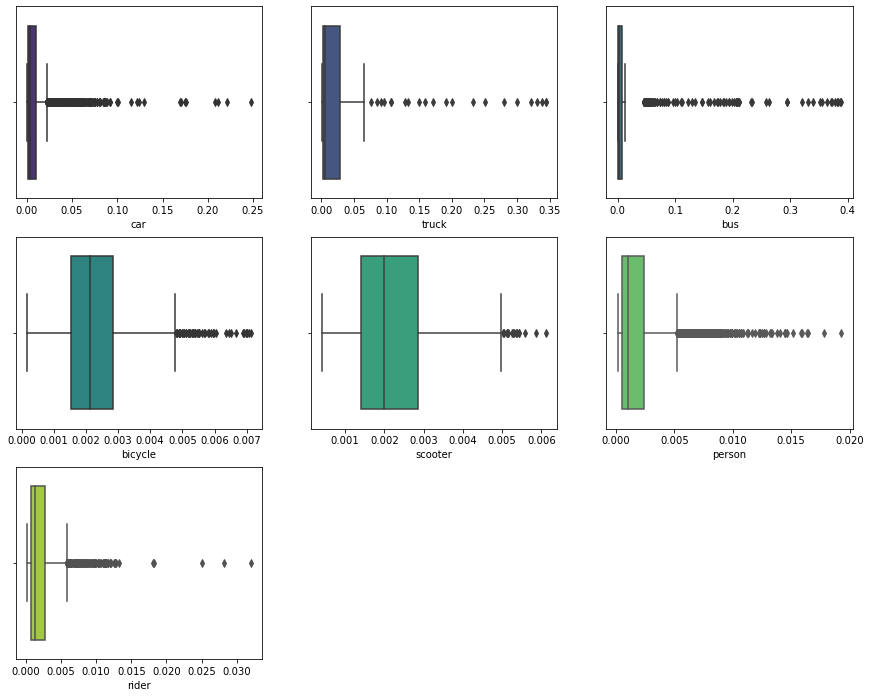

In [232]:
# Too big difference in ranges for this plot to be useful
# sns.catplot(x="label", y="rel_area", data=bbox_df, kind="box", palette="viridis", height=10)

# Try plotting individual boxplots for each label
cols = 3
rows = 3
# num_cols = bbox_df.select_dtypes(exclude='object').columns

palette = sns.color_palette("viridis", 7)

fig = plt.figure(figsize=(15, 12))
# plt.title('Boxplot of relative area of bounding box per class')

true_object_labels = [x for x in object_labels.values() if x != 'motorcycle']

i = 0
for label in true_object_labels:
    ax = fig.add_subplot(rows, cols, i + 1)
    sns.boxplot(x=bbox_df[bbox_df['label'] == label]['rel_area'], ax=ax, color=palette[i]).set(xlabel=label)
    i += 1


We see that objects can be separated from each other by considering their height and width. This is not always the case, e.g. it is easier to differentiate buses and trucks from cars, than scooters from persons.

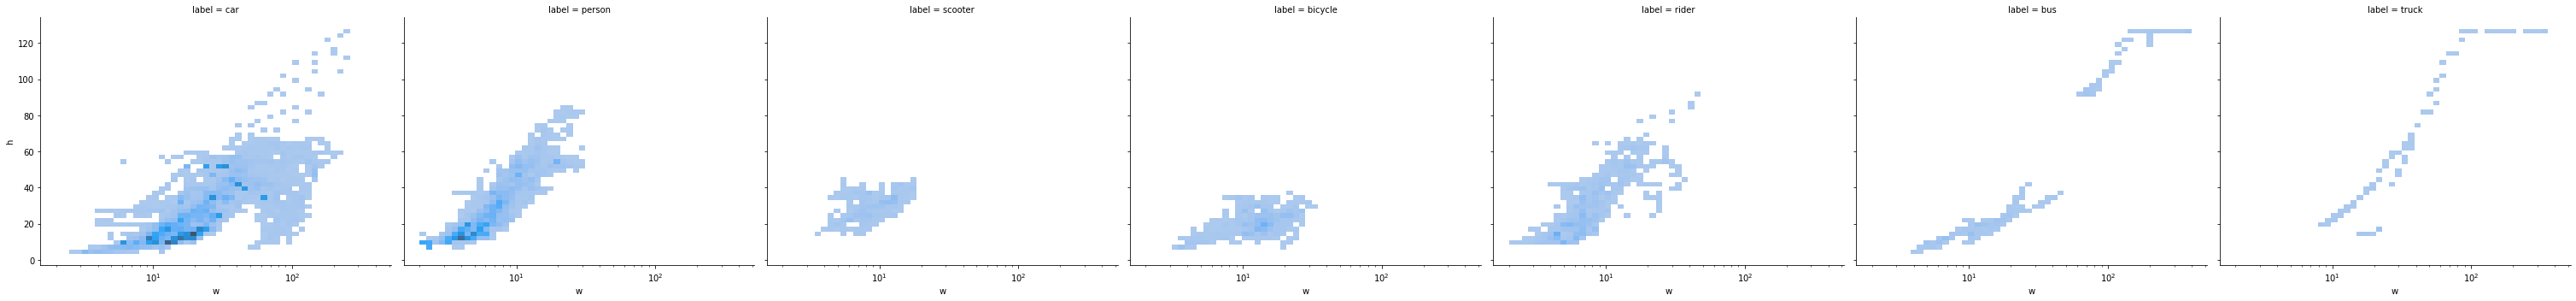

In [187]:
# 2D histogram with density by color for each category
sns.displot(
  data=bbox_df,
  x="w",
  y="h",
  col="label",
  kind="hist",
  height=5,
  aspect=1.2,
  log_scale=(10,0),
  bins=50
)

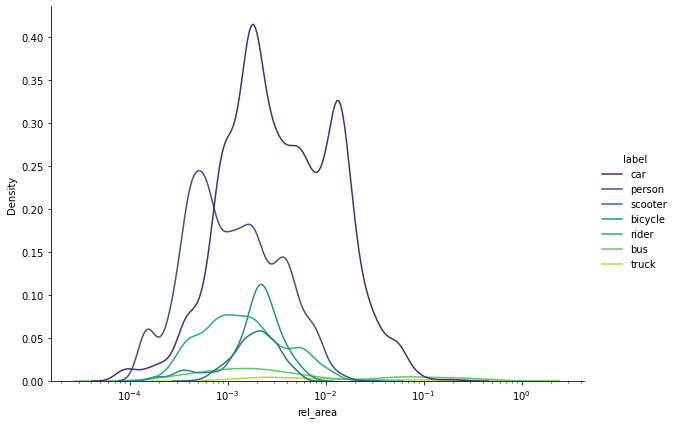

In [193]:
# Plot density of rel_area by category
sns.displot(
  data=bbox_df,
  x="rel_area",
  hue="label",
  kind="kde",
  height=6,
  aspect=1.4,
  log_scale=10,
  palette="viridis"
)

/Users/mariu/opt/anaconda3/envs/tdt4265/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'aspect'
  cset = contour_func(
/Users/mariu/opt/anaconda3/envs/tdt4265/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


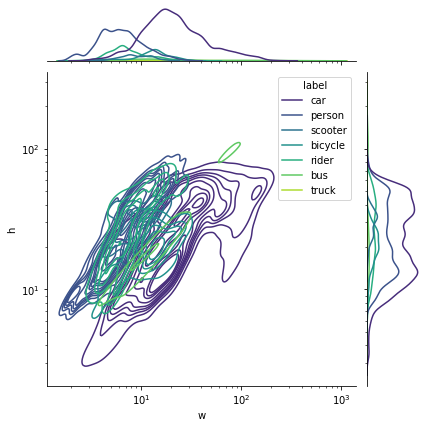

In [234]:
sns.jointplot(
    data=bbox_df,
    x="w",
    y="h",
    hue="label",
    kind="kde",
    aspect=1.4,
    log_scale=10,
    palette="viridis"
)

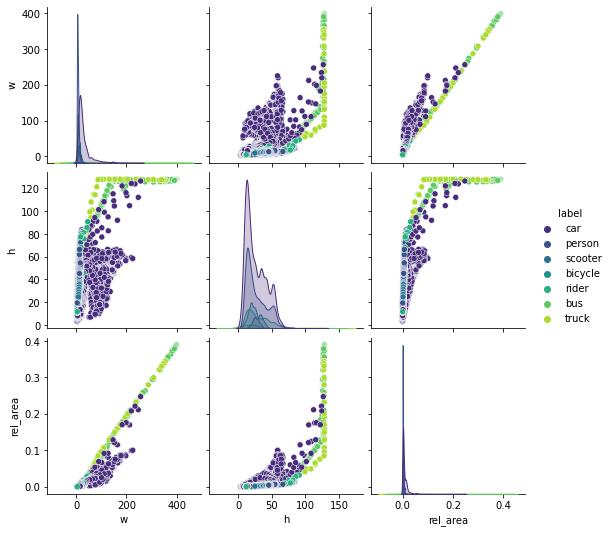

In [194]:
sns.pairplot(bbox_df, hue='label', palette='viridis', height=2.5)

None
